## Baseline NN - Double pendule

*Le 21/12*


In [1]:
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Paramètres physiques
g = 9.81  # Gravité
L1, L2 = 1.0, 1.0  # Longueurs des bras
m1, m2 = 1.0, 1.0  # Masses

Création des fonctions pour générer les données d'entrainement

In [3]:
def double_pendulum(t, y):
    theta1, theta2, theta1_dot, theta2_dot = y
    delta = theta1 - theta2

    theta1_ddot = (
        -g * (2 * m1 + m2) * np.sin(theta1)
        - m2 * g * np.sin(theta1 - 2 * theta2)
        - 2 * np.sin(delta) * m2 * (theta2_dot**2 * L2 + theta1_dot**2 * L1 * np.cos(delta))
    ) / (L1 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    theta2_ddot = (
        2
        * np.sin(delta)
        * (
            theta1_dot**2 * L1 * (m1 + m2)
            + g * (m1 + m2) * np.cos(theta1)
            + theta2_dot**2 * L2 * m2 * np.cos(delta)
        )
    ) / (L2 * (2 * m1 + m2 - m2 * np.cos(2 * delta)))

    return [theta1_dot, theta2_dot, theta1_ddot, theta2_ddot]

In [4]:
def check_energy(th1, th2, w1, w2, m1=1, m2=1, l1=1, l2=1, g=9.8):

  T = 0.5*(m1 + m2)*l1**2*w1**2 + 0.5*m2*l2**2*w2**2 + m2*l1*l2*w1*w2*jnp.cos(th1 - th2)
  V = (m1+m2)*g*l1*jnp.cos(th1) + m2*g*l2*jnp.cos(th2)

  return T - V

In [5]:
def generate_double_pendulum_data(num_samples, t_span, y0_range):
    """Génère des données pour le double pendule."""
    X, y = [], []
    for _ in range(num_samples):
        y0 = np.random.uniform(*y0_range, size=4)  # Conditions initiales
        sol = solve_ivp(double_pendulum, t_span, y0, t_eval=[t_span[0]])
        theta1, theta2, theta1_dot, theta2_dot = sol.y[:, 0]
        theta1_ddot, theta2_ddot = double_pendulum(0, [theta1, theta2, theta1_dot, theta2_dot])[2:]
        X.append([theta1, theta2, theta1_dot, theta2_dot])
        y.append([theta1_ddot, theta2_ddot])
    return np.array(X), np.array(y)

Paramètres de génération, on prend une range d'angle de $[-\pi, \pi]$ avec 100 000 points

In [6]:
t_span = [0, 0.01]
y0_range = [-np.pi, np.pi]
X_train, y_train = generate_double_pendulum_data(100000, t_span, y0_range)

Visualisation des données d'entrainement

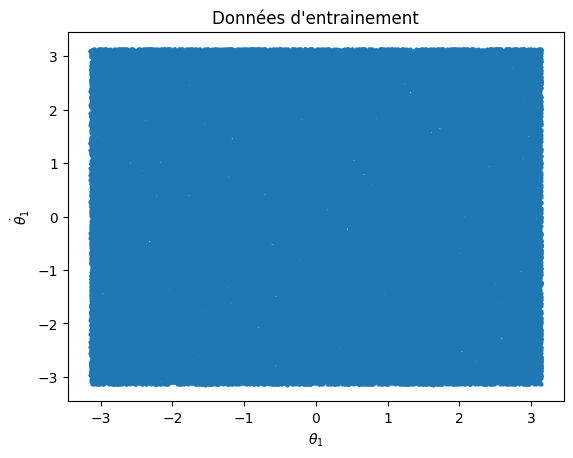

In [8]:
plt.plot(X_train[:, 0], X_train[:, 2], 'o', markersize=2)
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\dot{\\theta}_1$')
plt.title('Données d\'entrainement')
plt.show()

On définit le modèle du NN

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='softplus', input_shape=(4,)),
    tf.keras.layers.Dense(128, activation='softplus'),
    tf.keras.layers.Dense(2)  # Deux sorties : theta1_ddot et theta2_ddot
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,410 (68.01 KB)

 Trainable params: 17,410 (68.01 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=1)

Epoch 1/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 33.9202
Epoch 2/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.7959
Epoch 3/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.3520
Epoch 4/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.6128
Epoch 5/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.6242
Epoch 6/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8675
Epoch 7/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5919
Epoch 8/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4562
Epoch 9/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3642
Epoch 10/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3024
Epoch 11/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2453
Epoch 12/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2082
Epoch 13/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1828
Epoch 14/300
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1550
Epoch 15/300


## Construction de la trajectoire à partir d'une condition initiale.

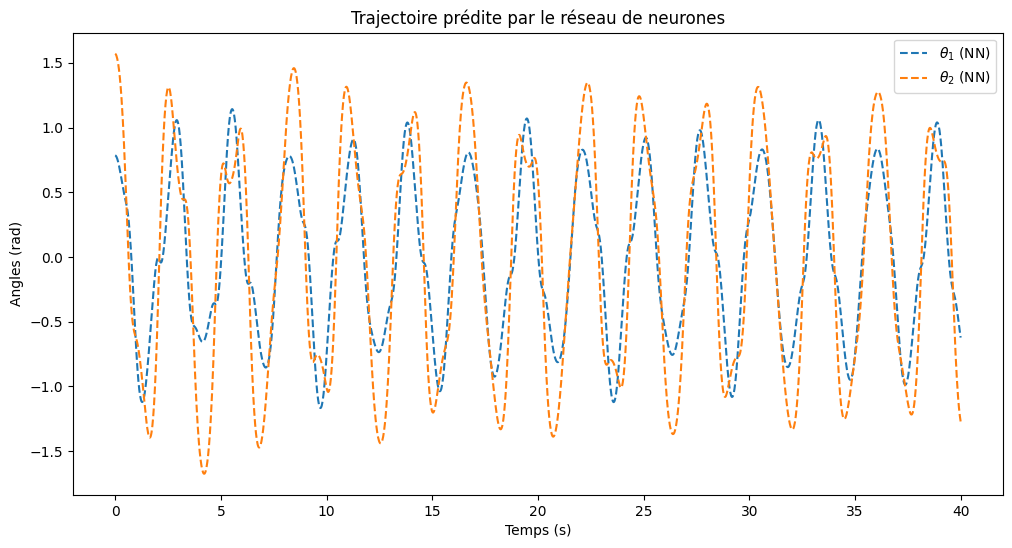

In [10]:
# Intégration pour prédire une trajectoire
def integrate_trajectory_double_pendulum(y0, dt, steps, model):
    """Construit une trajectoire en utilisant le NN et l'intégration d'Euler."""
    trajectory = [y0]
    y = np.array(y0)
    for _ in range(steps):
        y_ddot = model.predict(y[np.newaxis, :], verbose=0)[0]    #verbose = 0 permet de désactiver l'affichage des logs
        y[2:] += y_ddot * dt  # Mise à jour des vitesses angulaires
        y[:2] += y[2:] * dt  # Mise à jour des angles
        trajectory.append(y.copy())
    return np.array(trajectory)

# Trajectoire avec le NN
y0 = [np.pi / 4, np.pi/2, 0.0, 0.0]  # Conditions initiales
dt = 0.02
steps = 2000
trajectory_nn = integrate_trajectory_double_pendulum(y0, dt, steps, model)

# Visualisation des angles
time = np.linspace(0, steps * dt, steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(time, trajectory_nn[:, 0], label='$\\theta_1$ (NN)', linestyle='--')
plt.plot(time, trajectory_nn[:, 1], label='$\\theta_2$ (NN)', linestyle='--')
plt.xlabel("Temps (s)")
plt.ylabel("Angles (rad)")
plt.legend()
plt.title("Trajectoire prédite par le réseau de neurones")
plt.show()

### On veut récuperer la trajectoire analytique comme on l'a fait pour le LNN.

In [11]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial

from jax.example_libraries import stax
from jax.example_libraries import optimizers

In [12]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [13]:
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [16]:
x1 = np.array([np.pi / 4, np.pi/2, 0.0, 0.0])
x1_analytical = jax.device_get(solve_analytical(x1, time))

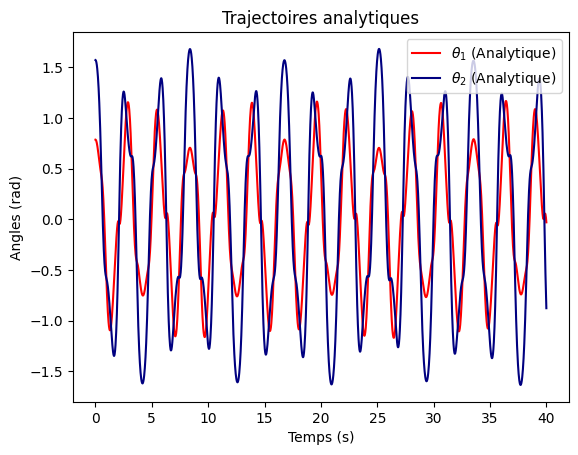

In [17]:
plt.plot(time, x1_analytical[:, 0], label='$\\theta_1$ (Analytique)', color='red')
plt.plot(time, x1_analytical[:, 1], label='$\\theta_2$ (Analytique)', color='navy')
plt.xlabel("Temps (s)")
plt.ylabel("Angles (rad)")
plt.title("Trajectoires analytiques")
plt.legend()

### Comparaison des deux

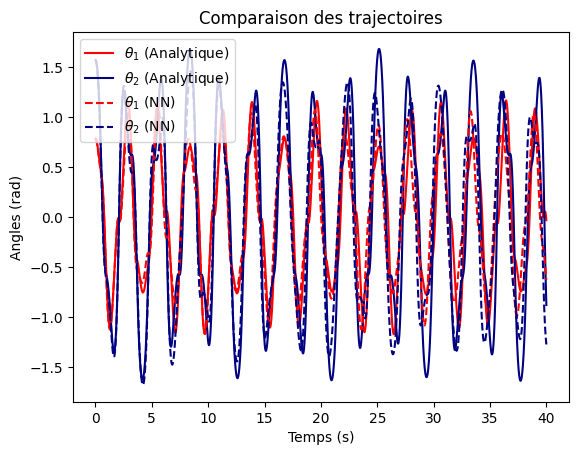

In [18]:
plt.plot(time, x1_analytical[:, 0], label='$\\theta_1$ (Analytique)', color='red')
plt.plot(time, x1_analytical[:, 1], label='$\\theta_2$ (Analytique)', color='navy')
plt.plot(time, trajectory_nn[:, 0], label='$\\theta_1$ (NN)', linestyle='--', color='red')
plt.plot(time, trajectory_nn[:, 1], label='$\\theta_2$ (NN)', linestyle='--', color='navy')
plt.xlabel("Temps (s)")
plt.ylabel("Angles (rad)")
plt.title("Comparaison des trajectoires")
plt.legend()

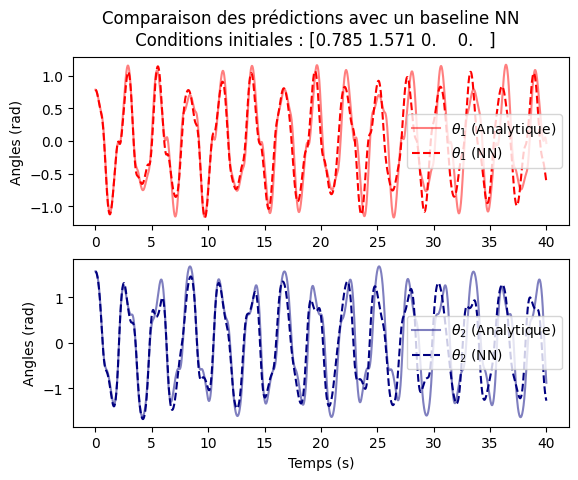

In [19]:
fig, axs = plt.subplots(2)
fig.suptitle('Comparaison des prédictions avec un baseline NN \n Conditions initiales : ' + str(np.round(y0, 3)))
axs[0].plot(time, x1_analytical[:, 0], label='$\\theta_1$ (Analytique)', color='red', alpha=0.5)
axs[1].plot(time, x1_analytical[:, 1], label='$\\theta_2$ (Analytique)', color='navy', alpha=0.5)
axs[0].plot(time, trajectory_nn[:, 0], label='$\\theta_1$ (NN)', linestyle='--', color='red')
axs[1].plot(time, trajectory_nn[:, 1], label='$\\theta_2$ (NN)', linestyle='--', color='navy')
#axs[0].set_xlabel("Temps (s)")
axs[0].set_ylabel("Angles (rad)")

axs[1].set_xlabel("Temps (s)")
axs[1].set_ylabel("Angles (rad)")

axs[0].legend(loc='right')
axs[1].legend(loc='right')

fig.savefig('NN_DoublePendule4.pdf', bbox_inches='tight')

In [20]:
from google.colab import files

# Download the figure
files.download('NN_DoublePendule4.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
energy_NN = check_energy(trajectory_nn[:, 0], trajectory_nn[:, 1], trajectory_nn[:, 2], trajectory_nn[:, 3])
energy_analytical = check_energy(x1_analytical[:, 0], x1_analytical[:, 1], x1_analytical[:, 2], x1_analytical[:, 3])

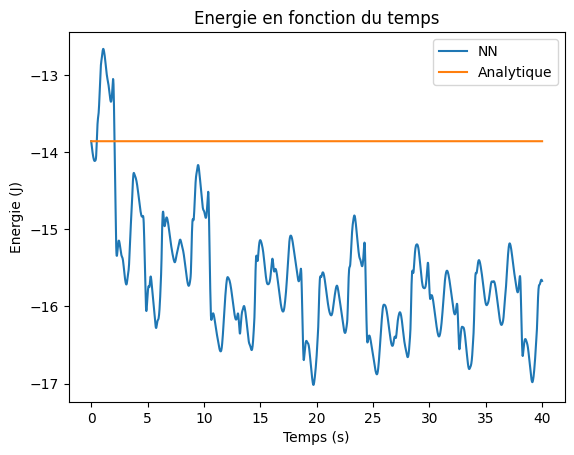

In [22]:
plt.plot(time, energy_NN, label='NN')
plt.plot(time, energy_analytical, label='Analytique')
plt.xlabel("Temps (s)")
plt.ylabel("Energie (J)")
plt.title("Energie en fonction du temps")
plt.legend()

In [23]:
np.save('y0.npy', y0)
np.save('time.npy', time)
np.save('trajectory_nn.npy', trajectory_nn)
np.save('x1_analytical.npy', x1_analytical)

files.download('trajectory_nn.npy')
files.download('x1_analytical.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
files.download('y0.npy')
files.download('time.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sauvegarde complète du modèle

In [25]:
model.save("double_pendulum_model.keras")

files.download("double_pendulum_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pour charger le modèle :

In [ ]:
# Charger le modèle complet
#from tensorflow.keras.models import load_model
#model = load_model("double_pendulum_model")

In [26]:
time

array([0.000e+00, 2.000e-02, 4.000e-02, ..., 3.996e+01, 3.998e+01,
       4.000e+01])

In [ ]:
time[-1]

40.0

In [ ]:
# prompt: génère moi cet array : array([0.000e+00, 2.000e-02, 4.000e-02, ..., 3.996e+01, 3.998e+01,
#        4.000e+01])

import numpy as np

# Create the array
time = np.linspace(0, 40, 2001)

time